In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import coolpy as cp
import subprocess

Step 1) Create file

In [3]:
# Define variables
abs_len = 1.27736269

Hsol_len = abs_len + 2*0.12
L_Lsol = 1 #[m]
M_Lsol = 0.2
Hcorr_Lsol = 0.012

nSheet = 5

L_current_density = 17
H_current_density = 535.3

L_radius_in  = 0.1 #[m] Low Field
L_radius_out = 0.3 #[m]
M_radius_in  = 0.1 # Matching field
M_radius_out = 0.3
H_radius_in  = 0.03 # High Field
H_radius_out = 0.09

Hcorr1_radius_out = 0.135 #outer most down and up stream correctors
Hcorr2_radius_out = 0.125 #middle  down and up stream correctors
Hcorr3_radius_out = 0.115 #inner most down and up stream correctors
Hcorr_rad_arr = [Hcorr1_radius_out, Hcorr2_radius_out, Hcorr3_radius_out]

MU_optimized_params = [34.07907333777548, 0.0, 3.3219755405093148, 51.652979865357764]
MD_optimized_params = np.array([35.59682398054068, -7.564106056579011, -12.110464700076378])

In [3]:
# Positions of solenoids
L1_pos = 0
L_Lgap = 0.4
L_MUgap = 0.1

L_Hgap = 0.1
L_MDgap = 0.25+0.1

MU_pos_arr = [(L_Lsol/2 + L_Lgap + L_MUgap*i + M_Lsol*i + M_Lsol/2) for i in range(4)]
H1_pos = MU_pos_arr[-1] + M_Lsol/2 + L_Hgap + Hsol_len/2 + Hcorr_Lsol*3
MD_pos_arr = [(H1_pos + Hcorr_Lsol*3 + Hsol_len/2 + L_Hgap + L_MDgap*i + M_Lsol*i + M_Lsol/2) for i in range(3)]

HcorrU_pos_arr = [(H1_pos - (Hsol_len*0.5 + Hcorr_Lsol*(3-i)) + Hcorr_Lsol*0.5) for i in range(3)]
HcorrD_pos_arr = [(H1_pos + (Hsol_len*0.5 + Hcorr_Lsol*(3-i)) - Hcorr_Lsol*0.5) for i in range(3)]


In [4]:
MU_pos_arr

[1.0, 1.3, 1.6, 1.9000000000000004]

In [5]:
H1_pos

2.8946813450000004

In [6]:
HcorrU_pos_arr

[2.1060000000000003, 2.1180000000000003, 2.1300000000000003]

In [7]:
# Define Solenoid Structures with coolpy
L1 = cp.SolenoidSheet(current_density=L_current_density, radius_inner=L_radius_in, radius_outer=L_radius_out, rho=0.0, L_sol=L_Lsol, nSheet=nSheet, position=L1_pos)
MU1_list = [cp.SolenoidSheet(current_density=MU_optimized_params[m], radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MU_pos_arr[m]) for m in [0, 2, 3]]
MD1_list = [cp.SolenoidSheet(current_density=MD_optimized_params[m], radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MD_pos_arr[m]) for m in range(3)]

H1 = cp.SolenoidSheet(current_density=H_current_density, radius_inner=H_radius_in, radius_outer=H_radius_out, rho=0.0, L_sol=Hsol_len, nSheet=nSheet, position=H1_pos)

HcorrU_solenoid_list = []
HcorrD_solenoid_list = []
for corr in range(3):
    print(Hcorr_rad_arr[corr])
    HcorrU = cp.SolenoidSheet(current_density=H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrU_pos_arr[corr])
    HcorrD = cp.SolenoidSheet(current_density=H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrD_pos_arr[corr])
    HcorrU_solenoid_list.append(HcorrU)
    HcorrD_solenoid_list.append(HcorrD)

0.135
0.125
0.115


In [ ]:
FCLattice = pd.DataFrame(columns=['element','name','centre','length','material','inner_radius','outer_radius','field_on-axis','current_density','nsheets','gradient','frequency','phase','wedge_angle'])

In [ ]:
FCLattice.loc[0] = pd.Series({'element':'solenoid', 'name':f'L0', 'centre':L1.position, 'length':L1.L_sol, 'inner_radius':L1.radius_inner, 'outer_radius':L1.radius_outer, 'field_on-axis':4, 'current_density':L1.current_density, 'nsheets':nSheet})
for mu, matcher in enumerate(MU1_list):
    FCLattice.loc[mu+1] = pd.Series({'element':'solenoid', 'name':f'MU{mu+1}', 'centre':matcher.position, 'length':matcher.L_sol, 'inner_radius':matcher.radius_inner, 'outer_radius':matcher.radius_outer, 'current_density':matcher.current_density, 'nsheets':nSheet})
for u, hcorr in enumerate(HcorrU_solenoid_list):
    FCLattice.loc[u+4] = pd.Series({'element':'solenoid', 'name':f'H{u//3+1}corr{u%3+1}_U', 'centre':hcorr.position, 'length':hcorr.L_sol, 'inner_radius':hcorr.radius_inner, 'outer_radius':hcorr.radius_outer, 'current_density':hcorr.current_density, 'nsheets':3})
FCLattice.loc[7] = pd.Series({'element':'solenoid', 'name':f'H1', 'centre':H1.position, 'length':H1.L_sol, 'inner_radius':H1.radius_inner, 'outer_radius':H1.radius_outer, 'field_on-axis':40, 'current_density':H1.current_density, 'nsheets':nSheet})

FCLattice.loc[8]    = pd.Series({'element':'absorber', 'name':f'abs1', 'centre':H1_pos, 'length':abs_len, 'material':'LH2', 'inner_radius':0, 'outer_radius':25*1E-3})

for u, hcorr in enumerate(HcorrD_solenoid_list):
    FCLattice.loc[u+9] = pd.Series({'element':'solenoid', 'name':f'H{u//3+1}corr{u%3+1}_D', 'centre':hcorr.position, 'length':hcorr.L_sol, 'inner_radius':hcorr.radius_inner, 'outer_radius':hcorr.radius_outer, 'current_density':hcorr.current_density, 'nsheets':nSheet})
for md, matcher in enumerate(MD1_list):
    FCLattice.loc[md+12] = pd.Series({'element':'solenoid', 'name':f'MD{md//10+1}_{md%10+1}', 'centre':matcher.position, 'length':matcher.L_sol, 'inner_radius':matcher.radius_inner, 'outer_radius':matcher.radius_outer, 'current_density':matcher.current_density, 'nsheets':nSheet})


NameError: name 'pd' is not defined

In [10]:
rf_rot_grad = 2*32
rf_grad = 32
acc_freq = 0
rot_freq = 50
acc_phase = 50
rf_len = 0.25

for rf, Matcher in enumerate(MD1_list[0:2]):
    rf1_pos= Matcher.position+0.25+0.05/2
    FCLattice.loc[rf+15] = pd.Series({'element':'pillbox', 'name':f'RF{rf}', 'centre':rf1_pos, 'length':rf_len, 'inner_radius':160*1E-3, 'gradient':rf_rot_grad, 'frequency':rot_freq, 'phase':0})

In [11]:
FCLattice

,element,name,centre,length,material,inner_radius,outer_radius,field_on-axis,current_density,nsheets,gradient,frequency,phase,wedge_angle
0,solenoid,L0,0,1,NaN,0.1,0.3,4,17,5,NaN,NaN,NaN,NaN
1,solenoid,MU1,1.0,0.2,NaN,0.1,0.3,NaN,34.079073,5,NaN,NaN,NaN,NaN
2,solenoid,MU2,1.6,0.2,NaN,0.1,0.3,NaN,3.321976,5,NaN,NaN,NaN,NaN
3,solenoid,MU3,1.9,0.2,NaN,0.1,0.3,NaN,51.65298,5,NaN,NaN,NaN,NaN
4,solenoid,H1corr1_U,2.106,0.012,NaN,0.03,0.135,NaN,535.3,3,NaN,NaN,NaN,NaN
5,solenoid,H1corr2_U,2.118,0.012,NaN,0.03,0.125,NaN,535.3,3,NaN,NaN,NaN,NaN
6,solenoid,H1corr3_U,2.13,0.012,NaN,0.03,0.115,NaN,535.3,3,NaN,NaN,NaN,NaN
7,solenoid,H1,2.894681,1.517363,NaN,0.03,0.09,40,535.3,5,NaN,NaN,NaN,NaN
8,absorber,abs1,2.894681,1.277363,LH2,0,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,solenoid,H1corr1_D,3.683363,0.012,NaN,0.03,0.135,NaN,535.3,5,NaN,NaN,NaN,NaN


In [13]:
FCLattice.to_csv('FinalCooling_benchmark_test.csv')

In [5]:
FCLattice = pd.read_csv('FinalCooling_benchmark_test.csv')

In [8]:
FCLattice['new_parameter'] =  0

In [10]:
FCLattice.to_json('benchmarking.json')

In [15]:
pd.read_json('benchmarking.json')

,Unnamed: 0,element,name,centre,length,material,inner_radius,outer_radius,field_on-axis,current_density,nsheets,gradient,frequency,phase,wedge_angle,new_parameter
0,0,solenoid,L0,0.000000,1.000000,None,0.10,0.300,4.0,17.000000,5.0,NaN,NaN,NaN,NaN,0
1,1,solenoid,MU1,1.000000,0.200000,None,0.10,0.300,NaN,34.079073,5.0,NaN,NaN,NaN,NaN,0
2,2,solenoid,MU2,1.600000,0.200000,None,0.10,0.300,NaN,3.321976,5.0,NaN,NaN,NaN,NaN,0
3,3,solenoid,MU3,1.900000,0.200000,None,0.10,0.300,NaN,51.652980,5.0,NaN,NaN,NaN,NaN,0
4,4,solenoid,H1corr1_U,2.106000,0.012000,None,0.03,0.135,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
5,5,solenoid,H1corr2_U,2.118000,0.012000,None,0.03,0.125,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
6,6,solenoid,H1corr3_U,2.130000,0.012000,None,0.03,0.115,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
7,7,solenoid,H1,2.894681,1.517363,None,0.03,0.090,40.0,535.300000,5.0,NaN,NaN,NaN,NaN,0
8,8,absorber,abs1,2.894681,1.277363,LH2,0.00,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,9,solenoid,H1corr1_D,3.683363,0.012000,None,0.03,0.135,NaN,535.300000,5.0,NaN,NaN,NaN,NaN,0


In [13]:
FCLattice.loc(1).frequency = 5

In [14]:
FCLattice

,Unnamed: 0,element,name,centre,length,material,inner_radius,outer_radius,field_on-axis,current_density,nsheets,gradient,frequency,phase,wedge_angle,new_parameter
0,0,solenoid,L0,0.000000,1.000000,NaN,0.10,0.300,4.0,17.000000,5.0,NaN,NaN,NaN,NaN,0
1,1,solenoid,MU1,1.000000,0.200000,NaN,0.10,0.300,NaN,34.079073,5.0,NaN,NaN,NaN,NaN,0
2,2,solenoid,MU2,1.600000,0.200000,NaN,0.10,0.300,NaN,3.321976,5.0,NaN,NaN,NaN,NaN,0
3,3,solenoid,MU3,1.900000,0.200000,NaN,0.10,0.300,NaN,51.652980,5.0,NaN,NaN,NaN,NaN,0
4,4,solenoid,H1corr1_U,2.106000,0.012000,NaN,0.03,0.135,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
5,5,solenoid,H1corr2_U,2.118000,0.012000,NaN,0.03,0.125,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
6,6,solenoid,H1corr3_U,2.130000,0.012000,NaN,0.03,0.115,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
7,7,solenoid,H1,2.894681,1.517363,NaN,0.03,0.090,40.0,535.300000,5.0,NaN,NaN,NaN,NaN,0
8,8,absorber,abs1,2.894681,1.277363,LH2,0.00,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,9,solenoid,H1corr1_D,3.683363,0.012000,NaN,0.03,0.135,NaN,535.300000,5.0,NaN,NaN,NaN,NaN,0


In [9]:
FCLattice

,Unnamed: 0,element,name,centre,length,material,inner_radius,outer_radius,field_on-axis,current_density,nsheets,gradient,frequency,phase,wedge_angle,new_parameter
0,0,solenoid,L0,0.000000,1.000000,NaN,0.10,0.300,4.0,17.000000,5.0,NaN,NaN,NaN,NaN,0
1,1,solenoid,MU1,1.000000,0.200000,NaN,0.10,0.300,NaN,34.079073,5.0,NaN,NaN,NaN,NaN,0
2,2,solenoid,MU2,1.600000,0.200000,NaN,0.10,0.300,NaN,3.321976,5.0,NaN,NaN,NaN,NaN,0
3,3,solenoid,MU3,1.900000,0.200000,NaN,0.10,0.300,NaN,51.652980,5.0,NaN,NaN,NaN,NaN,0
4,4,solenoid,H1corr1_U,2.106000,0.012000,NaN,0.03,0.135,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
5,5,solenoid,H1corr2_U,2.118000,0.012000,NaN,0.03,0.125,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
6,6,solenoid,H1corr3_U,2.130000,0.012000,NaN,0.03,0.115,NaN,535.300000,3.0,NaN,NaN,NaN,NaN,0
7,7,solenoid,H1,2.894681,1.517363,NaN,0.03,0.090,40.0,535.300000,5.0,NaN,NaN,NaN,NaN,0
8,8,absorber,abs1,2.894681,1.277363,LH2,0.00,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,9,solenoid,H1corr1_D,3.683363,0.012000,NaN,0.03,0.135,NaN,535.300000,5.0,NaN,NaN,NaN,NaN,0


In [13]:
def plot_solenoids(dataframe, cmap='viridis'):
    current_density_min = dataframe.current_density.min()
    current_density_min = dataframe.current_density.max()
    norm = mcolors.Normalize(vmin=-current_density_min, vmax=current_density_min)
    cmap = plt.colormaps.get_cmap(cmap)

    fig = plt.figure(figsize=(25,5))
    gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
    ax1 = fig.add_subplot(gs[0])
    plt.subplots_adjust(hspace=0)


    for index, solenoid in tqdm(dataframe[dataframe.element == 'solenoid'].iterrows()):
        color = cmap(norm(solenoid.current_density))

        rect_outer = patches.Rectangle(
            (solenoid.centre - solenoid.length / 2, solenoid.inner_radius),
            solenoid.length,
            solenoid.outer_radius,
            linewidth=1,
            edgecolor='k',
            facecolor=color
        )
        rect_inner = patches.Rectangle(
            (solenoid.centre - solenoid.length / 2, -solenoid.inner_radius),
            solenoid.length,
            -solenoid.outer_radius,
            linewidth=1,
            edgecolor='k',
            facecolor=color
        )
        ax1.add_patch(rect_outer)
        ax1.add_patch(rect_inner)

    ax1.set(xlim=(0, solenoid.centre+solenoid.length*4), ylim=(-0.5, 0.5))

In [14]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib as mpl
from tqdm.notebook import tqdm
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ff3645","#bf3a68","#803e8b", "#4042ad","#0046d0"])
cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0046d0","#4042ad", "#803e8b","#bf3a68","#ff3645"])

0it [00:00, ?it/s]

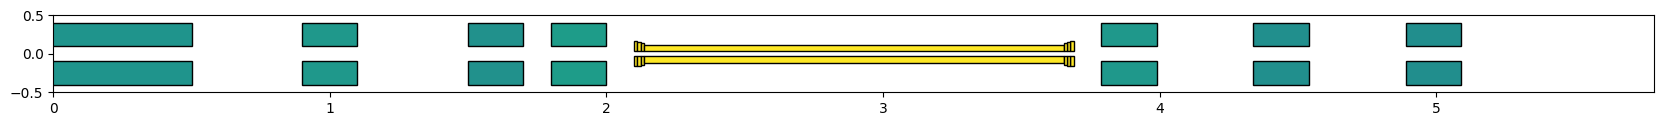

In [15]:
plot_solenoids(FCLattice)

## Lattice to RF Track

In [135]:
from RF_Track import Absorber, Solenoid, SW_Structure, Volume, Bunch6dT, muonlifetime, muonmass, Bunch6d_twiss, Bunch6d, nC, Lattice, Coil, Pillbox_Cavity
import RF_Track

In [136]:
V = Volume()
V.set_s0(0.0)
V.set_s1(FCLattice.centre.max())

In [137]:
V.dt_mm = 1.0 # mm/c
V.odeint_algorithm = 'analytic' # 'rk2', 'rkf45', 'leapfrog', ...
V.tt_dt_mm = 10.0  # mm/c, track the emittance every tt_dt_mm steps
V.cfx_dt_mm = 1.0
V.t_max_mm = 1E4

Using $B_0 = \mu_0 J R_{thickness}$

In [138]:
from tqdm.notebook import tqdm

In [139]:
def Bz_from_J(solenoid):
    mu_0 = 1.257E-6 #Tm/A
    B0 = 1E6*mu_0*solenoid.current_density * (solenoid.outer_radius - solenoid.inner_radius)
    return(B0)

Importing solenoids to RF Track

In [140]:
for index, element in tqdm(FCLattice[FCLattice.element == 'solenoid'].iterrows()):
    print(element.name, Bz_from_J(element))
    solenoid_element = Solenoid(element.length, Bz_from_J(element), element.inner_radius, element.outer_radius, int(element.nsheets))
    V.add(solenoid_element, 0, 0, element.centre, 'center')

0it [00:00, ?it/s]

0 4.2738
1 8.567479037116755
2 0.8351446508840416
3 12.985559138150938
4 70.6515705
5 63.92284949999999
6 57.1941285
7 40.372325999999994
9 70.6515705
10 63.92284949999999
11 57.1941285
12 8.949041548707925
13 -1.9016162626239628
14 -3.044570825599201


Importing cavities to RF Track

In [ ]:
for index, element in tqdm(FCLattice[FCLattice.element == 'pillbox'].iterrows()):
    print(element.gradient*1E6)
    cavity_element = Pillbox_Cavity(element.gradient*1E6, element.frequency*1E9, element.length, 1)
    cavity_element.set_phid(element.phase - 90)
    V.add(cavity_element, 0, 0, element.centre, 'center');

0it [00:00, ?it/s]

64000000.0
64000000.0


Importing absorbers to RF Track

In [185]:
for index, element in tqdm(FCLattice[FCLattice.element == 'absorber'].iterrows()):
    absorber_element = Absorber(element.length, 'liquid_hydrogen')
    print(element.length, element.centre)
    V.add(absorber_element, 0, 0, element.centre, 'center')

0it [00:00, ?it/s]

1.27736269 2.8946813450000004


In [ ]:
FCLattice[FCLattice.element == 'absorber']

In [143]:
B_long_arr = []
E_long_arr = []
Z_arr = []
zstep = 50
z_arr = np.arange(0, 4989, zstep)
for z in z_arr:
    e_b_fields = V.get_field(0, 0, int(z), 0)
    B_long_arr.append(e_b_fields[1][2])
    E_long_arr.append(e_b_fields[0][2])
    Z_arr.append(z)

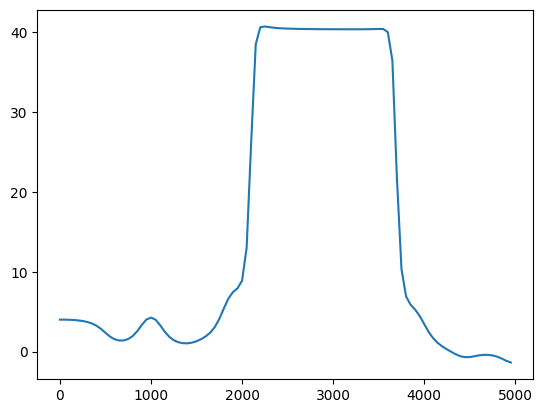

In [144]:
plt.plot(Z_arr, B_long_arr)

## Lattice to G4BL

In [145]:
FCLattice

,Unnamed: 0,element,name,centre,length,material,inner_radius,outer_radius,field_on-axis,current_density,nsheets,gradient,frequency,phase,wedge_angle
0,0,solenoid,L0,0.000000,1.000000,NaN,0.10,0.300,4.0,17.000000,5.0,NaN,NaN,NaN,NaN
1,1,solenoid,MU1,1.000000,0.200000,NaN,0.10,0.300,NaN,34.079073,5.0,NaN,NaN,NaN,NaN
2,2,solenoid,MU2,1.600000,0.200000,NaN,0.10,0.300,NaN,3.321976,5.0,NaN,NaN,NaN,NaN
3,3,solenoid,MU3,1.900000,0.200000,NaN,0.10,0.300,NaN,51.652980,5.0,NaN,NaN,NaN,NaN
4,4,solenoid,H1corr1_U,2.106000,0.012000,NaN,0.03,0.135,NaN,535.300000,3.0,NaN,NaN,NaN,NaN
5,5,solenoid,H1corr2_U,2.118000,0.012000,NaN,0.03,0.125,NaN,535.300000,3.0,NaN,NaN,NaN,NaN
6,6,solenoid,H1corr3_U,2.130000,0.012000,NaN,0.03,0.115,NaN,535.300000,3.0,NaN,NaN,NaN,NaN
7,7,solenoid,H1,2.894681,1.517363,NaN,0.03,0.090,40.0,535.300000,5.0,NaN,NaN,NaN,NaN
8,8,absorber,abs1,2.894681,1.277363,LH2,0.00,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,solenoid,H1corr1_D,3.683363,0.012000,NaN,0.03,0.135,NaN,535.300000,5.0,NaN,NaN,NaN,NaN


In [146]:
setup = f'''
g4ui when=4 "/vis/viewer/set/background 1 1 1"
param disable=Decay   #Whether muons decay
param stochastics=1
physics QGSP_BIC disable=$disable
param cell_end={FCLattice.centre.max()*1E3}
param zstep={zstep}
'''

absorber_list = []
i = 0
for index, element in tqdm(FCLattice[FCLattice.element == 'absorber'].iterrows()):
    absorber_str = f'''
tube {element['name']} length={element.length*1E3} material={element.material} innerRadius={element.inner_radius*1E3} outerRadius={element.outer_radius*1E3} color=1,1,1,1
place {element['name']} z={element.centre*1E3:.2f}
'''
    absorber_list.append(absorber_str)
    i+=1

solenoid_list = []
color='0,0,1,0.5'
for index, element in tqdm(FCLattice[FCLattice.element == 'solenoid'].iterrows()):
    solenoid_str = f'''
coil {element['name']}_C innerRadius={element.inner_radius*1E3} outerRadius={element.outer_radius*1E3} length={element.length*1E3} nSheets={element.nsheets} tolerance=1 maxZ=1000
solenoid {element['name']} coil={element['name']}_C current={element.current_density} color={color}
place {element['name']} z={element.centre*1E3:.2f}
    '''
    solenoid_list.append(solenoid_str)

rf_list = []
for index, element in tqdm(FCLattice[FCLattice.element == 'pillbox'].iterrows()):
    rf_str = f'''
pillbox {element['name']} innerLength={element.length*1E3} timeOffset=0 maxGradient={element.gradient} frequency={1E-3*element.frequency} innerRadius={element.inner_radius*1E3} phaseAcc={element.phase} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place {element['name']} z={element.centre*1E3:.2f}
    '''
    rf_list.append(rf_str)

fieldmap = f'''
reference particle=mu+ beamZ=0 referenceMomentum=200 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
fieldntuple field_out format=ascii filename='Benchmark_g4bl_fieldmap' x=0 y=0 z=0,$cell_end,$zstep
'''
#

N=1000
beamdef = f'''
zntuple output file=291025_benchmark_{N}.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={N} # user provided file with particle data
trackcuts keep=mu+
'''

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [147]:
with open(f'G4BL_benchmark.g4bl', "w") as f:
    f.write(setup)
    for string in absorber_list:
        f.write(string)
    for string in solenoid_list:
        f.write(string)
    for string in rf_list:
        f.write(string)
    f.write(beamdef)
    f.write(fieldmap)

In [148]:
subprocess.run([r"/mnt/c/Program Files/Muons, Inc/G4beamline/bin/g4bl.exe", f"G4BL_benchmark.g4bl"])

G4BL_DIR=C:\Program Files\Muons, Inc\G4beamline
G4LEDATA=C:\Geant4Data/G4EMLOW8.0
G4ENSDFSTATEDATA=C:\Geant4Data/G4ENSDFSTATE2.3
G4PARTICLEXSDATA=C:\Geant4Data/G4PARTICLEXS4.0
G4LEVELGAMMADATA=C:\Geant4Data/PhotonEvaporation5.7
G4RADIOACTIVEDATA=C:\Geant4Data/RadioactiveDecay5.6
G4beamline Process ID 14724

*************************************************************
 g4beamline version: 3.08                        (Oct  8 2022)
                      Copyright : Tom Roberts, Muons, Inc.
                        License : Gnu Public License
                            WWW : http://g4beamline.muonsinc.com
**************************************************************
 Geant4 version Name: geant4-11-00-patch-03 [MT]   (16-September-2022)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
              

CompletedProcess(args=['/mnt/c/Program Files/Muons, Inc/G4beamline/bin/g4bl.exe', 'G4BL_benchmark.g4bl'], returncode=0)

In [149]:
fieldmap = pd.read_csv('Benchmark_g4bl_fieldmap.txt', skiprows=2, names=['x', 'y', 'z', 't', 'Bx', 'By', 'Bz', 'Ex', 'Ey', 'Ez'], usecols=[0,1,2,3,4,5,6,7,8,9], delimiter=' ')

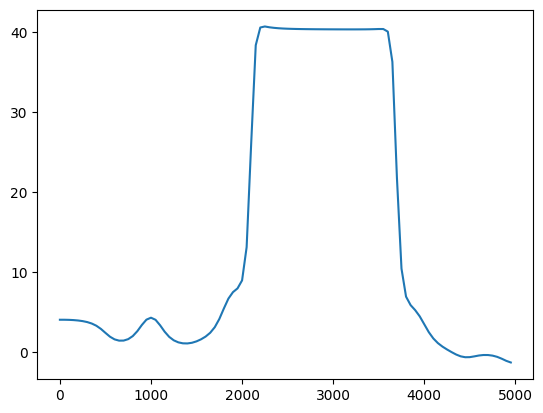

In [150]:
plt.plot(fieldmap.z, fieldmap.Bz)

### Comparing the two solenoids

(Text(0.5, 0, 'Z [mm]'), Text(0, 0.5, 'Bz on-axis [T]'))

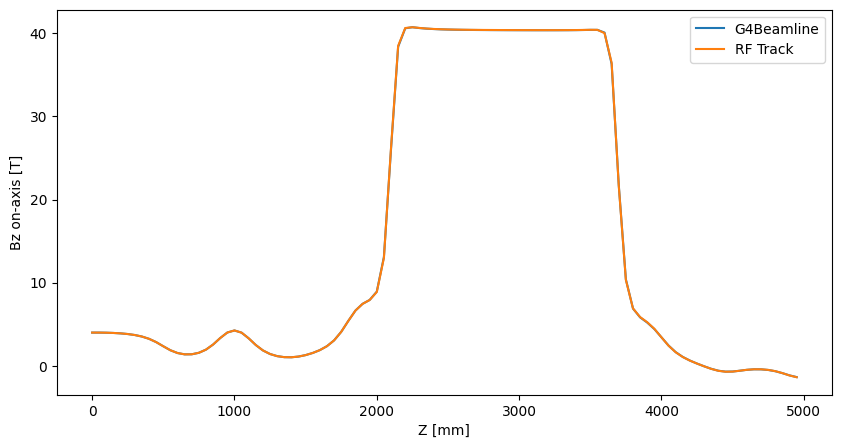

In [151]:
plt.figure(figsize=(10,5))
plt.plot(fieldmap.z, fieldmap.Bz, label='G4Beamline')
plt.plot(Z_arr, B_long_arr, label='RF Track')
plt.legend()
plt.xlabel('Z [mm]'), plt.ylabel('Bz on-axis [T]')

(Text(0.5, 0, 'Z [mm]'), Text(0, 0.5, 'Bz on-axis [T]'))

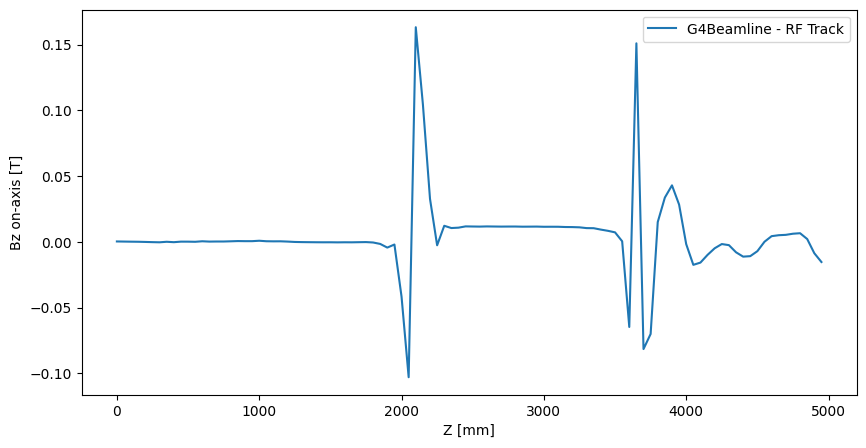

In [152]:
plt.figure(figsize=(10,5))
plt.plot(fieldmap.z, B_long_arr - fieldmap.Bz, label='G4Beamline - RF Track')
plt.legend()
plt.xlabel('Z [mm]'), plt.ylabel('Bz on-axis [T]')

#### Comparing the two RF
Notes: G4BL is in MV and RFT is in V. Conversion required

(Text(0.5, 0, 'Z [mm]'), Text(0, 0.5, 'Ez on-axis [MV]'))

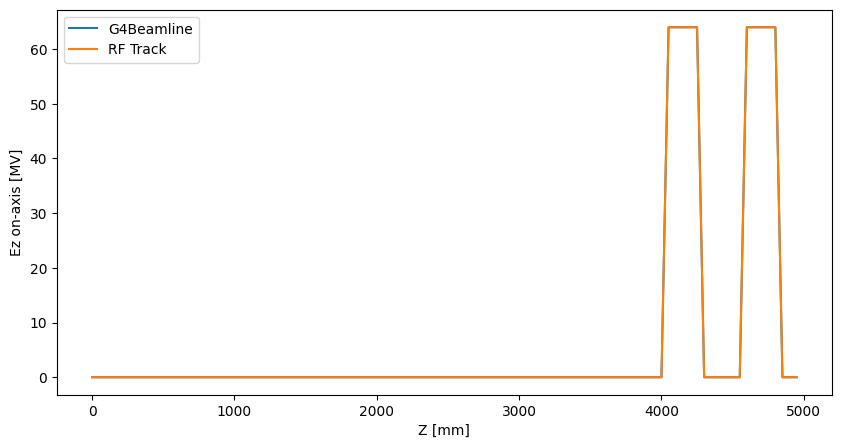

In [153]:
plt.figure(figsize=(10,5))
plt.plot(fieldmap.z, fieldmap.Ez, label='G4Beamline')
plt.plot(Z_arr, np.array(E_long_arr)*1E-6, label='RF Track')
plt.legend()
plt.xlabel('Z [mm]'), plt.ylabel('Ez on-axis [MV]')

(Text(0.5, 0, 'Z [mm]'), Text(0, 0.5, 'Ez on-axis [MV]'))

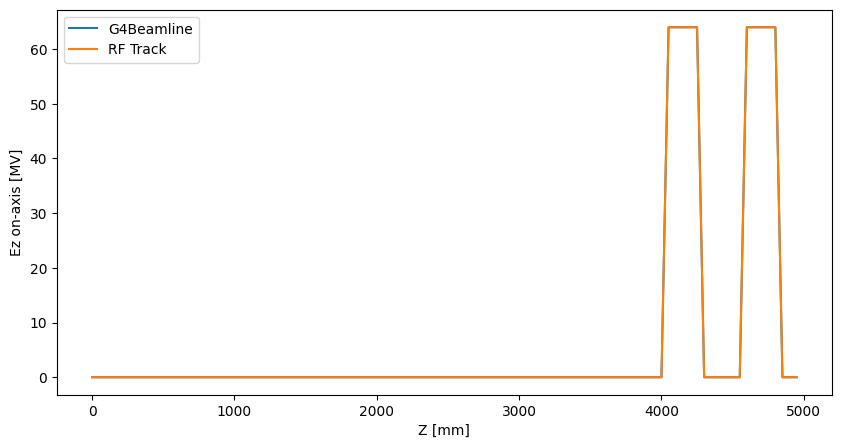

In [154]:
plt.figure(figsize=(10,5))
plt.plot(fieldmap.z, fieldmap.Ez, label='G4Beamline')
plt.plot(Z_arr, np.array(E_long_arr)*1E-6, label='RF Track')
plt.legend()
plt.xlabel('Z [mm]'), plt.ylabel('Ez on-axis [MV]')

Comparing beam optics

In [155]:
g4tracks = pd.read_csv(f'291025_benchmark_{N}.txt', skiprows=3, names=['IEVT', 'IPNUM', 'IPTYP', 'T', 'X', 'Y', 'Z', 'Px', 'Py', 'Pz'], usecols=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11], delimiter=' ')

In [156]:
g4tracks

,IEVT,IPNUM,IPTYP,T,X,Y,Z,Px,Py,Pz
0,0,1,2,0.000000e+00,0.000000,0.000000,0.00,0.000000,0.000000,0.200000
1,1,0,2,2.209640e-11,-0.010067,-0.004721,0.00,-0.015433,0.011959,0.192236
2,2,0,2,-7.473360e-11,-0.011682,-0.008301,0.00,0.001899,0.008322,0.193644
3,3,0,2,-7.121570e-11,0.001089,0.000574,0.00,-0.001099,-0.004707,0.214445
4,4,0,2,-7.057030e-11,0.000701,0.003440,0.00,-0.003627,0.003037,0.202484
...,...,...,...,...,...,...,...,...,...,...
100095,996,0,2,1.931880e-08,0.012218,0.034925,4.95,-0.006014,0.006873,0.177628
100096,997,0,2,1.905860e-08,-0.010853,0.007900,4.95,-0.002217,-0.000806,0.169919
100097,998,0,2,1.884220e-08,0.001944,0.027725,4.95,-0.006000,0.002513,0.186215
100098,999,0,2,1.935210e-08,-0.002028,0.001673,4.95,-0.001173,-0.003404,0.175188


In [157]:
input_beam = pd.read_csv('050625BeamInput_10000_4.04124T.txt', skiprows=2, names=['x', 'y', 'z', 'Px', 'Py', 'Pz', 't'], usecols=[0,1,2,3,4,5,6], delimiter=' ', nrows=N)

In [158]:
input_beam 

,x,y,z,Px,Py,Pz,t
0,-10.067423,-4.721196,0,-15.433116,11.959031,192.236299,0.022096
1,-11.681674,-8.300881,0,1.899044,8.321900,193.643796,-0.074734
2,1.089247,0.574268,0,-1.098918,-4.707432,214.444861,-0.071216
3,0.700759,3.440270,0,-3.627131,3.037410,202.484160,-0.070570
4,5.907416,2.287591,0,1.002381,4.939043,207.595605,-0.092235
...,...,...,...,...,...,...,...
995,9.245554,6.433888,0,10.471821,-3.264038,202.413273,0.117834
996,0.027995,-5.248505,0,-6.913310,-1.643107,198.240186,-0.235583
997,4.480711,-1.535213,0,-7.023537,-1.546223,212.331616,-0.026349
998,-8.534925,12.244563,0,5.843878,7.824110,197.371378,0.051926


In [159]:
macro = np.zeros((N, 6))
macro[:,0], macro[:,2], macro[:,4] = input_beam.x, input_beam.y, input_beam.t
macro[:,1] = (input_beam.Px) / (input_beam.Pz)
macro[:,3] = (input_beam.Py) / (input_beam.Pz)
macro[:,5] = np.sqrt(input_beam.Px**2 + input_beam.Py**2 + input_beam.Pz**2)

In [160]:
population = 1e10
Q = +1

B0 = RF_Track.Bunch6d(RF_Track.muonmass, population, Q, macro)
B0.set_lifetime(RF_Track.muonlifetime)

In [161]:
nscreens = int(FCLattice.centre.max()*1E3 / zstep)

In [162]:

L = Lattice();
L.append_ref(V)
L.set_tt_nsteps(100);
B1 = L.track(B0);
I1 = B1.get_info()
PS0 = B0.get_phase_space('%x %Px %y %Py %t %Pz %id')
PS1 = B1.get_phase_space('%x %Px %y %Py %t %Pz %id')



(Text(0.5, 0, 'Z [mm]'), Text(0, 0.5, 'Pz [MeV]'))

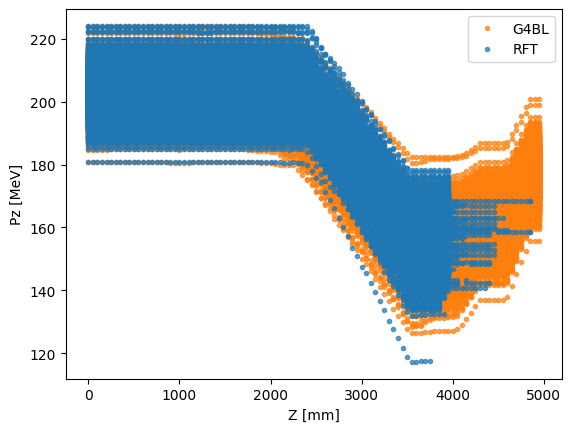

In [194]:

plt.plot(g4tracks['Z']*1E3, g4tracks.Pz*1E3, '.', color='tab:orange', alpha=0.7, label='G4BL')

for b, bunch in enumerate(L.get_bunch_at_screens()):
        bunch_dist = bunch.get_phase_space('%x %Px %y %Py %t %Pz %id')
        plt.plot(50*b*np.ones(len(bunch_dist[:,5])), bunch_dist[:,5], '.', color='tab:blue', alpha=0.7)
plt.plot(50*b*np.ones(len(bunch_dist[:,5])), bunch_dist[:,5], '.', color='tab:blue', alpha=0.7, label='RFT')
plt.legend()
plt.xlabel('Z [mm]'), plt.ylabel('Pz [MeV]')

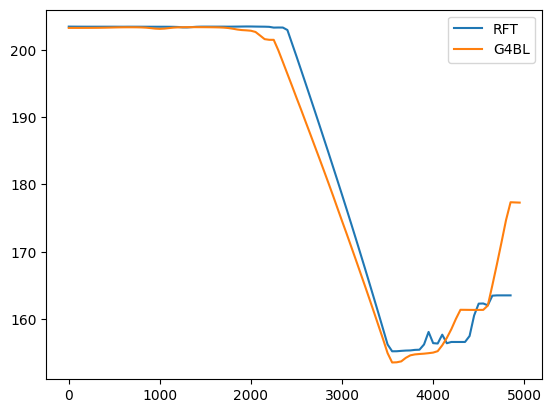

In [214]:
RFT_pz_av = []
RFT_x_av = []
RFT_px_av = []
RFT_y_av = []
RFT_py_av = []
RFT_z = []
for b, bunch in enumerate(L.get_bunch_at_screens()):
        bunch_dist = bunch.get_phase_space('%x %Px %y %Py %t %Pz %id')
        RFT_x_av.append(np.mean(bunch_dist[:,0]))
        RFT_px_av.append(np.mean(bunch_dist[:,1]))
        RFT_y_av.append(np.mean(bunch_dist[:,2]))
        RFT_py_av.append(np.mean(bunch_dist[:,3]))
        RFT_pz_av.append(np.mean(bunch_dist[:,5]))
        RFT_z.append(50*b)

G4BL_pz_av = []
G4BL_x_av = []
G4BL_px_av = []
G4BL_y_av = []
G4BL_py_av = []
G4BL_z = g4tracks.Z.unique()
for z, z_unique in enumerate(G4BL_z):
    G4BL_pz_av.append(1E3*g4tracks[g4tracks.Z == z_unique].Pz.mean())
    G4BL_x_av.append(1E3*g4tracks[g4tracks.Z == z_unique].X.mean())
    G4BL_px_av.append(1E3*g4tracks[g4tracks.Z == z_unique].Px.mean())
    G4BL_y_av.append(1E3*g4tracks[g4tracks.Z == z_unique].Y.mean())
    G4BL_py_av.append(1E3*g4tracks[g4tracks.Z == z_unique].Py.mean())

plt.plot(RFT_z, RFT_pz_av, label='RFT')
plt.plot(G4BL_z*1E3, G4BL_pz_av, label='G4BL')
plt.legend()

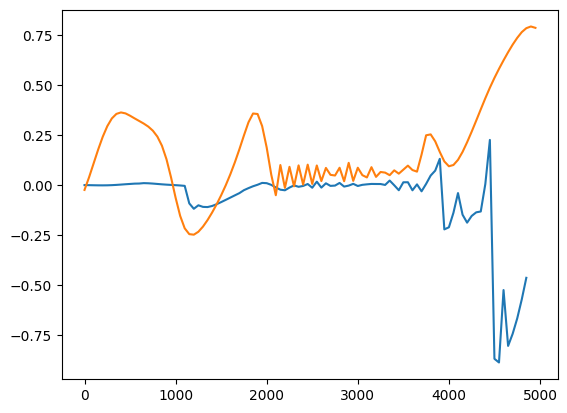

In [215]:
plt.plot(RFT_z, RFT_x_av)
plt.plot(G4BL_z*1E3, G4BL_x_av)

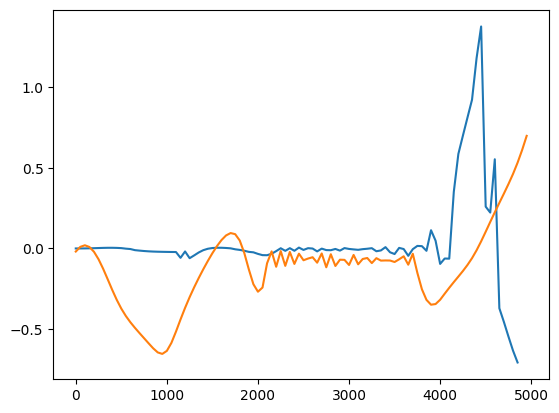

In [216]:
plt.plot(RFT_z, RFT_y_av)
plt.plot(G4BL_z*1E3, G4BL_y_av)

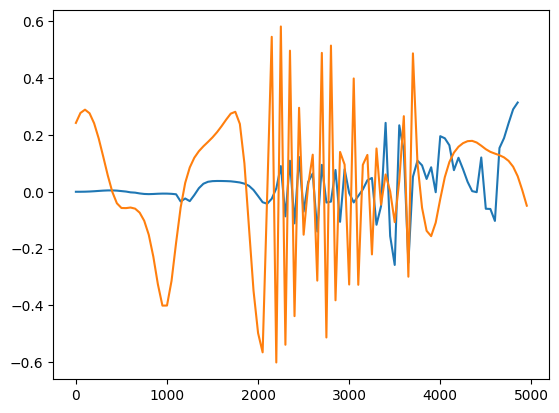

In [220]:
plt.plot(RFT_z, RFT_px_av)
plt.plot(G4BL_z*1E3, G4BL_px_av)